# Part III. Compare intensity matrices

- Now that we have color matrices for every image, we can compare reference vs experiment picture intensities
- Identify those colonies with highest intensity differences and match them with the corresponding genes
- We only consider the colonies where at least 3 out of 4 repetions have high intensity differences

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from glob import glob
import os

import pandas as pd
from importlib import reload
from skimage import exposure

# Step 1. Load the appropriate data

- Just like in prior notebooks
- Also load the gene data `data` csv
- Define which gene index `lgdix` to compare to which gene control index `mgidx`

In [3]:
reference_foldername = 'Control'
reference_gene = 'EV'

fs = 15

#data = pd.read_csv('..' + os.sep + 'library_eY2H.csv')

src = '..' + os.sep + 'proc' + os.sep
lsrc = src + 'leyre' + os.sep

msrc = src + reference_foldername + os.sep + reference_gene + os.sep
dst = '..' + os.sep + 'proc' + os.sep
diagdst = '..' + os.sep + 'diagnostic' + os.sep

genes = sorted(os.listdir(lsrc))
print('Reference:\t', reference_gene, '\nGenes to test:\t', genes, sep='')

Reference:	EV
Genes to test:	['547', 'BHLH121', 'LBD37']


In [4]:
gidx = 0
print('Comparing gene', genes[gidx], 'with reference', reference_gene )
gdst = dst + lsrc.split(os.sep)[-2] + os.sep + genes[gidx] + os.sep
print('Will save all results in ',gdst)
ddst = diagdst + lsrc.split(os.sep)[-2] + os.sep + genes[gidx] + os.sep

Comparing gene 547 with reference EV
Will save all results in  ../proc/leyre/547/


# Step 2. Standardize intensities

- It can well be the case that the red intensity values in control are different from the red intensities in our pictures
- We thus match intensity histograms so that their cumulative distributions coincide
- That way differences are more meaningful
- `platenum`: Specify which plate number to compare

In [5]:
platenum = 1

ref_file = glob(msrc + '*_{:02d}_colormatrix.csv'.format(platenum) )[0]
plate_file = glob(lsrc + genes[gidx] + os.sep + '*_{:02d}_colormatrix.csv'.format(platenum) )[0]
bname = '_'.join((os.path.split(os.path.splitext(plate_file)[0])[1]).split('_')[:-1])

print(ref_file, plate_file, bname, sep='\n')

../proc/Control/EV/EV_plate_01_colormatrix.csv
../proc/leyre/547/547_plate_01_colormatrix.csv
547_plate_01


In [6]:
reference = np.loadtxt(ref_file, delimiter=',')
plate = np.loadtxt(plate_file, delimiter=',')
nrows, ncols = plate.shape
nonzeros = plate != 0

reference[~nonzeros] = 0
matched = exposure.match_histograms(plate, reference, channel_axis=None)

diff = reference - matched
diff[~nonzeros] = 0
vlim = np.max( np.abs( [ np.min(diff), np.max(diff) ] ) )

rhist, bins = np.histogram(reference, bins=range(1,257))
phist, _ = np.histogram(plate, bins=bins)
mhist, _ = np.histogram(matched, bins=bins)

imgsize = np.sum(nonzeros)
rcumsum = np.cumsum(rhist)/reference.size
pcumsum = np.cumsum(phist)/imgsize
mcumsum = np.cumsum(mhist)/imgsize

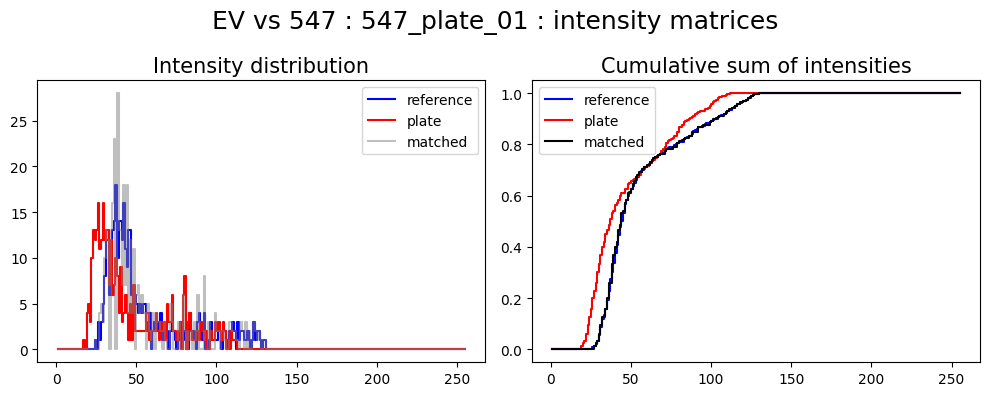

In [7]:
fig, ax = plt.subplots(1,2, figsize=(10,4), sharex=False, sharey=False)
ax = np.atleast_1d(ax).ravel(); i = 0

ax[i].plot(bins[:-1], rhist, c='blue', ds='steps', label='reference')
ax[i].plot(bins[:-1], phist, c='red', ds='steps', label='plate')
ax[i].plot(bins[:-1], mhist, c='gray', ds='steps', alpha=0.5, label='matched')
ax[i].set_title('Intensity distribution', fontsize=fs)

i+=1
ax[i].plot(bins[:-1], rcumsum, c='blue', ds='steps', label='reference')
ax[i].plot(bins[:-1], pcumsum, c='red', ds='steps', label='plate')
ax[i].plot(bins[:-1], mcumsum, c='k', ds='steps', label='matched')
ax[i].set_title('Cumulative sum of intensities', fontsize=fs)

for i in range(len(ax)):
    ax[i].legend();

fig.suptitle(reference_gene + ' vs ' + genes[gidx] + ' : ' + bname + ' : intensity matrices', fontsize=fs+3)
fig.tight_layout()

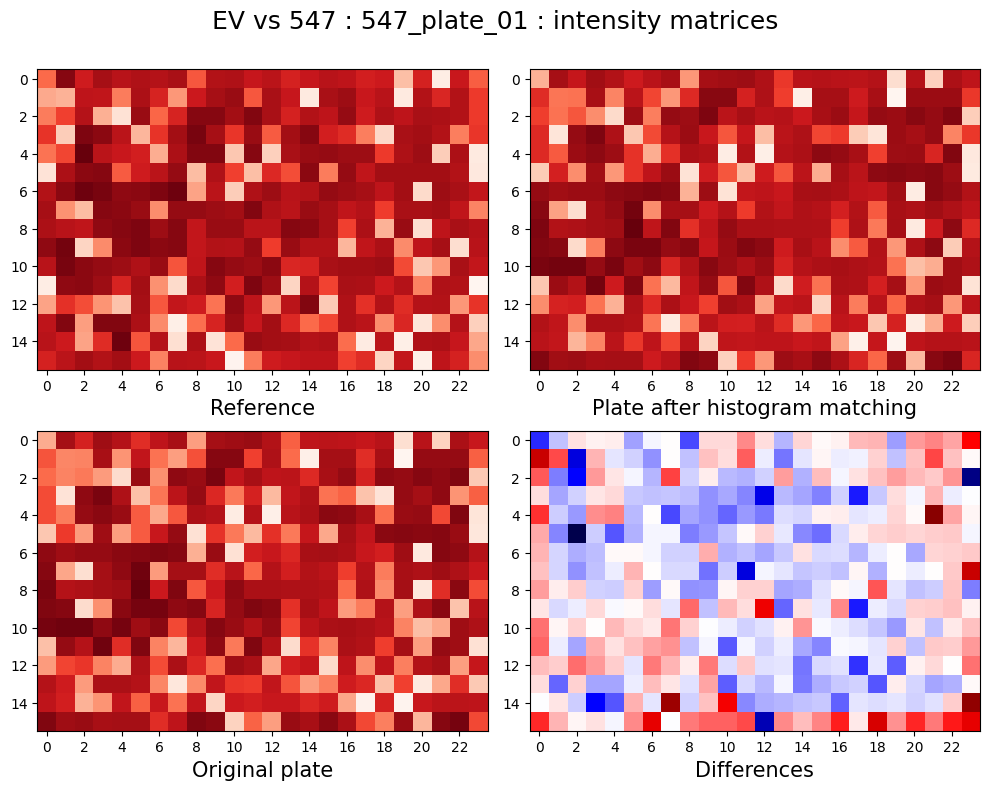

In [8]:
fig, ax = plt.subplots(2,2, figsize=(10,8), sharex=False, sharey=False)
ax = np.atleast_1d(ax).ravel(); i = 0

ax[0].imshow(reference, cmap='Reds_r')
ax[0].set_xlabel('Reference', fontsize=fs)
ax[1].imshow(matched, cmap='Reds_r')
ax[1].set_xlabel('Plate after histogram matching', fontsize=fs)
ax[2].imshow(plate, cmap='Reds_r')
ax[2].set_xlabel('Original plate', fontsize=fs)
ax[3].imshow(diff, cmap='seismic', vmin=-vlim, vmax=vlim)
ax[3].set_xlabel('Differences', fontsize=fs)

for i in range(len(ax)):
    ax[i].set_xticks(range(0,ncols,2), range(0,ncols,2))
    ax[i].set_yticks(range(0,nrows,2), range(0,nrows,2));
    ax[i].set_aspect('equal')

fig.suptitle(reference_gene + ' vs ' + genes[gidx] + ' : ' + bname + ' : intensity matrices', fontsize=fs+3)
fig.tight_layout()

# Step 3. Find outliers

### The mean differences are NOT normal

- Taking the average of the four intensity differences per gene, I noticed that these `means` are **not** normally distributed
- Thus a t-Test is not advised
- Better tests like Wilcoxon have less a priori restrictions
- But just 4 samples per gene is too small to do any meaningful statistics

## What then if not t-Tests?

- So far I've noticed that the differences follow a Laplace distribution
- This is purely a visual assessment and have no real idea on why this could be the case (stats is not my strength)
- The Laplace distribution by definition is a symmetric exponential distribution.
- But I don't see right away anything here that can be related to the exponential distribution.
- My best guess has to do with the fact that if $X_1, X_2, X_3, X_4$ are random variables that follow a normal distributions [then](https://en.wikipedia.org/wiki/Laplace_distribution#Related_distributions):
$$X_1X_2 - X_3X_4 \sim (X_1^2-X_2^2+X_3^2-X_4^2)/2 \sim Laplace$$
- And that the [product of two normal random variables](https://math.stackexchange.com/questions/101062/is-the-product-of-two-gaussian-random-variables-also-a-gaussian) tends to be the linear combination of two $\chi^2$-distributions.

In [9]:
repsr, repsc = 1,1

means = np.zeros((nrows//repsr, ncols//repsc))
for i in range(0,nrows,repsr):
    for j in range(0, ncols, repsc):
        means[i//repsr,j//repsc] = np.mean(diff[i:i+repsr, j:j+repsc])

dhist, dbins = np.histogram(diff[nonzeros], bins=np.linspace(-vlim-1, vlim+1, 101), density=True)
dcumsum = np.cumsum(dhist)
dcdf = (dcumsum - dcumsum[0])/(dcumsum[-1] - dcumsum[0])
xvals = dbins[:-1].copy()

meanhist, _ = np.histogram(means, bins=dbins, density=True)
meancumsum = np.cumsum(meanhist)
meancdf = (meancumsum - meancumsum[0])/(meancumsum[-1] - meancumsum[0])

mu, sigma = np.mean(diff), np.std(diff)
normal = 1/(np.std(diff) * np.sqrt(2 * np.pi))*np.exp( - (xvals - np.mean(diff))**2 / (2 * np.std(diff)**2))
ncumsum = np.cumsum(normal)
ncdf = (ncumsum - ncumsum[0])/(ncumsum[-1] - ncumsum[0])

b = np.std(diff)/np.sqrt(2)
laplace = np.exp(-abs(xvals)/b)/(2.*b)

lcdf = np.zeros(len(xvals))
lcdf[xvals < 0] = 0.5*np.exp((xvals[xvals < 0])/b)
lcdf[xvals >= 0] = 1-0.5*np.exp(-(xvals[xvals >= 0])/b)
print(' -- Empirical mean:\t', mu, '\n -- Empirical std:\t', sigma, '\n -- Max difference:\t', vlim, sep='')

 -- Empirical mean:	-0.09411219206141001
 -- Empirical std:	12.537123089060746
 -- Max difference:	56.75


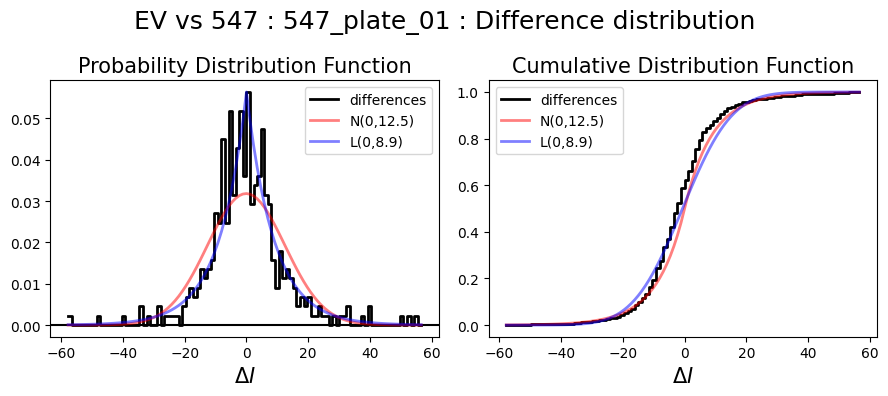

In [14]:
fig, ax = plt.subplots(1,2, figsize=(9,4), sharex=False, sharey=False)
ax = np.atleast_1d(ax).ravel(); i = 0

ax[i].axhline(0, c='k')
ax[i].plot(xvals, dhist, c='k', lw=2, ds='steps-post', label='differences', zorder=1)
#ax[i].plot(xvals, mhist, c='green', lw=2, ds='steps', label='means', alpha=0.5, zorder = 2)
ax[i].plot(xvals, normal, c='red', lw=2, label='N(0,{:.1f})'.format(sigma), alpha=0.5 , zorder = 3)
ax[i].plot(xvals, laplace, c='blue', lw=2, label='L(0,{:.1f})'.format(b), alpha=0.5, zorder = 4 )
ax[i].set_title('Probability Distribution Function', fontsize=fs)

i+=1
ax[i].plot(xvals, dcdf, c='k', label='differences', ds='steps', lw=2, alpha=1, zorder=1)
#ax[i].plot(xvals, dcdf, c='green', label='means', ds='steps', lw=2, alpha=1, zorder=2)
ax[i].plot(xvals, lcdf, c='r', label='N(0,{:.1f})'.format(sigma), lw=2, alpha=0.5, zorder=3)
ax[i].plot(xvals, ncdf, c='b', label='L(0,{:.1f})'.format(b), lw=2, alpha=0.5, zorder=4)
ax[i].set_title('Cumulative Distribution Function', fontsize=fs)

for i in range(len(ax)):
    ax[i].legend();
    ax[i].set_xlabel('$\Delta I$', fontsize=fs)
fig.suptitle(reference_gene + ' vs ' + genes[gidx] + ' : ' + bname + ' : Difference distribution', fontsize=fs+3)
fig.tight_layout()

filename = ddst + 'difference_distribution_' + bname + '.jpg'
#plt.savefig(filename, format='jpg', dpi=100, bbox_inches='tight', pil_kwargs={'optimize':True})

# Assuming that intensity differences follow a Laplace distribution

- Fix a small $\alpha$ value (like `alpha = 0.01`)
- I will ignore `1 - 2*alpha` (0.98 in this case) of Laplace central mass
- I will only consider difference values that have only `alpha` probability to happen (2% chance in this case)
- That is, I will only consider values that happen at the end tails of the Laplace distribution

## Alternative to find outliers

- The differences that are 3 standard deviations away from the mean (which should be 0)
- Differences larger than $Q_3 + 1.5\times IQR$ or smaller than $Q_1 - 1.5\times IQR$, like when making a [box plot](https://en.wikipedia.org/wiki/Box_plot). IQR is the inter-quartile range.

Assuming differences follow a Laplace distribution, we only consider the 5.0% of mass

Only considering differences larger than	26.55742050189004
Or smaller than	-26.55742050189004
---

Otherwise, we simply consider those differences that are 2 standard deviations away from the mean

Only considering differences larger than	25.07424617812149
Or smaller than	-25.07424617812149
---


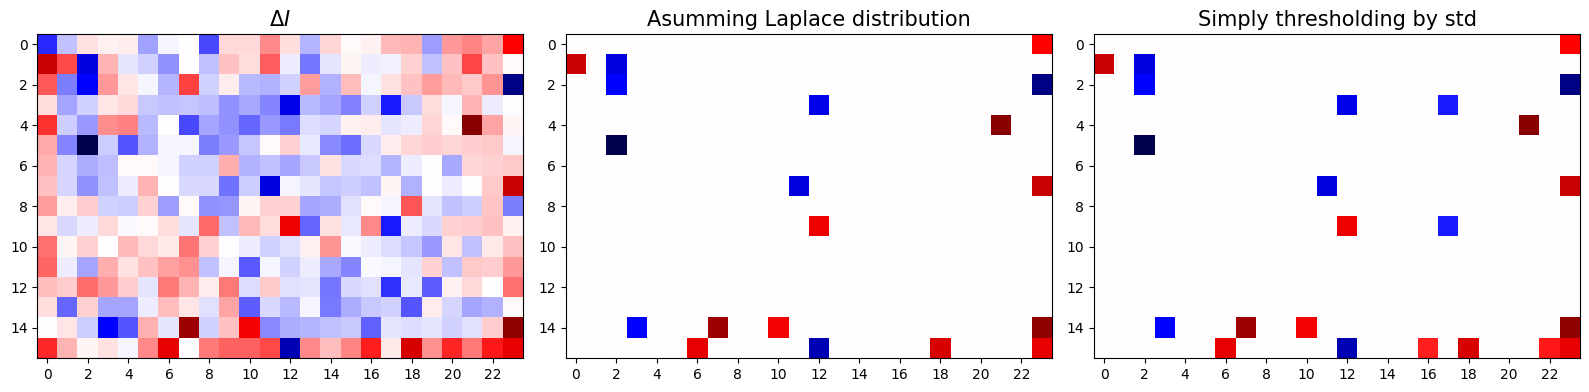

In [15]:
# FIND OUTLIERS BY SOME CRITERIA

# 1. Assume differences follow a Laplace distrubution. Outliers will be those outside the 1-alpha interval
alpha = 0.025
print('Assuming differences follow a Laplace distribution, we only consider the {:.1f}% of mass\n'.format(alpha*2*100))
lthreshold = np.abs(b * np.log(2*alpha))
print('Only considering differences larger than\t', lthreshold, '\nOr smaller than\t', -lthreshold, sep='')
ltmask = np.abs(diff) > lthreshold

# 2. Outliers are those 3 stds away from the mean
sigmalim=2
print('---\n\nOtherwise, we simply consider those differences that are {} standard deviations away from the mean\n'.format(sigmalim))
sthreshold = sigmalim*np.std(diff)
print('Only considering differences larger than\t', sthreshold, '\nOr smaller than\t', -sthreshold, '\n---', sep='')
stmask = np.abs(diff) > sthreshold

# 3. Outliers will be those outside far away from the IQR, like when making boxplots
#q1,q3 = np.quantile(diff, [0.2,0.8]); iqr = q1 - q3
#tmask = (diff < q1 - 1.5*iqr) | (diff > q3 + 1.5*iqr)

fig, ax = plt.subplots(1,3, figsize=(16,5), sharex=False, sharey=False)
ax = np.atleast_1d(ax).ravel(); i = 0

ax[0].imshow(diff, cmap='seismic', vmin=-vlim, vmax=vlim)
ax[0].set_title('$\\Delta I$', fontsize=fs)
ax[1].imshow(diff*ltmask, cmap='seismic', vmin=-vlim, vmax=vlim)
ax[1].set_title('Asumming Laplace distribution', fontsize=fs)
ax[2].imshow(diff*stmask, cmap='seismic', vmin=-vlim, vmax=vlim)
ax[2].set_title('Simply thresholding by std', fontsize=fs)

for i in range(len(ax)):
    ax[i].set_xticks(range(0,ncols,2), range(0,ncols,2))
    ax[i].set_yticks(range(0,nrows,2), range(0,nrows,2));
fig.tight_layout()

# Step 4. Match differences to gene database

- Only consider the colonies where at least 3 out of 4 have significant intensity differences.
- Based on row and column information, we match our results with the gene database
- The genes are sumarized in a dataframe `signif`
- We also keep record of the intensity difference and a quick reminder of the color of the colonies

In [20]:
datafile = 'library_eY2H_384Singleton_NewPlate6.csv'
data = pd.read_csv('..' + os.sep + datafile)

def get_significant_summary(tmask, threshold=2):
    signifscores = np.zeros(means.shape, dtype=np.uint8)

    for i in range(0,nrows,repsr):
        for j in range(0, ncols, repsc):
            signifscores[i//repsr, j//repsc] = np.sum(tmask[i:i+repsr, j:j+repsc])
    
    signifcoords = np.asarray(np.nonzero(signifscores > threshold))
    
    signifidx = np.zeros(len(signifcoords[0]), dtype=int) - 1
    diffvals = np.zeros(len(signifidx))
    
    for i in range(len(signifidx)):
        coordinate = 'p{:02d}-r{:02d}-c{:02d}'.format(platenum, signifcoords[0,i]+1, signifcoords[1,i]+1)
        ref = data[data['Coordinate'] == coordinate]
        if len(ref) > 0:
            signifidx[i] = ref.index[0]
            diffvals[i] = means[signifcoords[0,i], signifcoords[1,i]]
    
    signifmask = signifidx > -1
    
    signif = data.loc[signifidx[signifmask]]
    signif['IntensityDiff'] = diffvals[signifmask]
    signif['SigmaValue'] = diffvals[signifmask]/sigma
    signif['AlphaValue'] = np.where(diffvals[signifmask] < 0, .5*np.exp(diffvals[signifmask]/b), 1-.5*np.exp(-diffvals[signifmask]/b) )
    signif['ReferenceColor'] = np.where(diffvals[signifmask] < 0, 'redish', 'whiteish')
    signif['ControlColor'] = np.where(diffvals[signifmask] < 0, 'whiteish', 'redish')
    signif.sort_values(by='IntensityDiff', axis=0, ascending=False, key=np.abs, inplace=True)

    return signif

In [22]:
lsignif = get_significant_summary(ltmask, 0)
ssignif = get_significant_summary(stmask, 0)
print(lsignif.shape, ssignif.shape)
ssignif.head()

(19, 11) (23, 11)


,Identifier,Coordinate,Family,Common_Name,SubCellular,SubOrganellar,IntensityDiff,SigmaValue,AlphaValue,ReferenceColor,ControlColor
122,AT2G44150,p01-r06-c03,SET,SDG7,Nucleus,Chromosome,-56.750000,-4.526557,0.000830,redish,whiteish
117,AT1G13450,p01-r05-c22,TRIHELIX,GT-1,Nucleus,Chromosome,54.333333,4.333796,0.998911,whiteish,redish
359,AT1G74840,p01-r15-c24,MYB-related,AT1G74840,Nucleus,"Nucleus, nucleolus; Nucleus speckle; Chromosome",52.692308,4.202903,0.998689,whiteish,redish
343,AT2G40620,p01-r15-c08,bZIP,bZIP18,Nucleus,"Nucleus, nucleolus; Nucleus, nucleoplasm; Nucl...",50.000000,3.988156,0.998224,whiteish,redish
71,AT4G25560,p01-r03-c24,MYB,AtMYB18,Nucleus,"Nucleus, nucleolus; Nucleus speckle; Chromosome",-47.500000,-3.788748,0.002355,redish,whiteish


# Step 5. Save the results

In [23]:
filename = gdst + reference_gene + '_vs_' + bname + '_laplace_significant_differences.csv'
print(filename)
lsignif.to_csv(filename, index=True, index_label='OriginalIndex')

filename = gdst + reference_gene + '_vs_' + bname + '_sigma_significant_differences.csv'
print(filename)
ssignif.to_csv(filename, index=True, index_label='OriginalIndex')

../proc/leyre/547/EV_vs_547_plate_01_laplace_significant_differences.csv
../proc/leyre/547/EV_vs_547_plate_01_sigma_significant_differences.csv


Saved image ../diagnostic/leyre/547/difference_detection_summary_547_plate_01.jpg


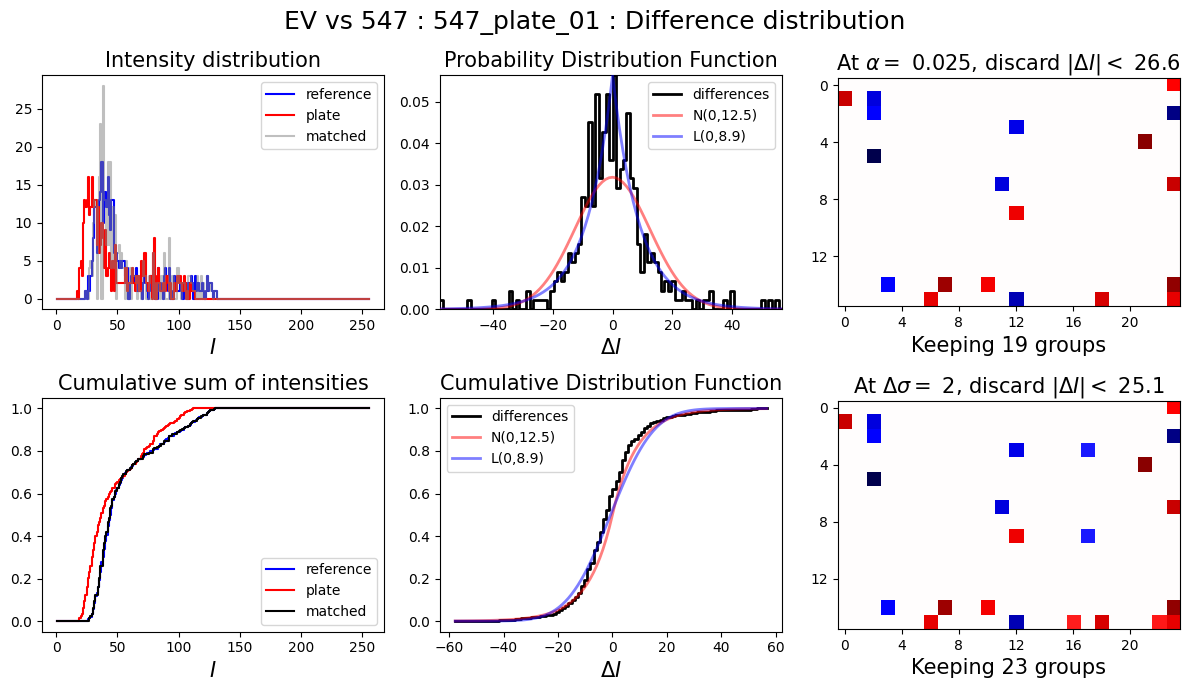

In [24]:
fig, ax = plt.subplots(2,3, figsize=(12,7), sharex=False, sharey=False)
ax = np.atleast_1d(ax).ravel(); i = 0

ax[i].plot(bins[:-1], rhist, c='blue', ds='steps', label='reference')
ax[i].plot(bins[:-1], phist, c='red', ds='steps', label='plate')
ax[i].plot(bins[:-1], mhist, c='gray', ds='steps', alpha=0.5, label='matched')
ax[i].set_title('Intensity distribution', fontsize=fs)

i+=1
ax[i].margins(0)
ax[i].plot(xvals, dhist, c='k', lw=2, ds='steps-post', label='differences', zorder=1)
#ax[i].plot(xvals, mhist, c='green', lw=2, ds='steps', label='means', alpha=0.5, zorder = 2)
ax[i].plot(xvals, normal, c='red', lw=2, label='N(0,{:.1f})'.format(sigma), alpha=0.5 , zorder = 3)
ax[i].plot(xvals, laplace, c='blue', lw=2, label='L(0,{:.1f})'.format(b), alpha=0.5, zorder = 4 )
ax[i].set_title('Probability Distribution Function', fontsize=fs)

i+=1
ax[i].imshow(diff*ltmask, cmap='seismic', vmin=-vlim, vmax=vlim)
ax[i].set_xlabel('Keeping {} groups'.format(len(lsignif)), fontsize=fs)
ax[i].set_title('At $\\alpha=$ {}, discard $|\\Delta I| <$ {:.1f}'.format(alpha, lthreshold), fontsize=fs)

i+=1
ax[i].plot(bins[:-1], rcumsum, c='blue', ds='steps', label='reference')
ax[i].plot(bins[:-1], pcumsum, c='red', ds='steps', label='plate')
ax[i].plot(bins[:-1], mcumsum, c='k', ds='steps', label='matched')
ax[i].set_title('Cumulative sum of intensities', fontsize=fs)

i+=1
ax[i].plot(xvals, dcdf, c='k', label='differences', ds='steps', lw=2, alpha=1, zorder=1)
#ax[i].plot(xvals, dcdf, c='green', label='means', ds='steps', lw=2, alpha=1, zorder=2)
ax[i].plot(xvals, lcdf, c='r', label='N(0,{:.1f})'.format(sigma), lw=2, alpha=0.5, zorder=3)
ax[i].plot(xvals, ncdf, c='b', label='L(0,{:.1f})'.format(b), lw=2, alpha=0.5, zorder=4)
ax[i].set_title('Cumulative Distribution Function', fontsize=fs)

i+=1
ax[i].imshow(diff*stmask, cmap='seismic', vmin=-vlim, vmax=vlim)
ax[i].set_xlabel('Keeping {} groups'.format(len(ssignif)), fontsize=fs)
ax[i].set_title('At $\\Delta\\sigma=$ {}, discard $|\\Delta I| <$ {:.1f}'.format(sigmalim, sthreshold), fontsize=fs)

for i in [0,3]:
    ax[i].set_xlabel('$I$', fontsize=fs)
for i in [1,4]:
    ax[i].set_xlabel('$\\Delta I$', fontsize=fs)
for i in [2,5]:
    ax[i].set_xticks(range(0,ncols,4), range(0,ncols,4))
    ax[i].set_yticks(range(0,nrows,4), range(0,nrows,4));
for i in [0,1,3,4]:
    ax[i].legend()

fig.suptitle(reference_gene + ' vs ' + genes[gidx] + ' : ' + bname + ' : Difference distribution', fontsize=fs+3)
fig.tight_layout()

filename = ddst + 'difference_detection_summary_' + bname + '.jpg'
print('Saved image',filename)
#plt.savefig(filename, format='jpg', dpi=100, bbox_inches='tight', pil_kwargs={'optimize':True})

# Just for mental sanity

- Let's plot the colonies that were reported with high intensity differences to visually check that they make sense and it is not just an illumination artifact.

In [61]:
rsrc = '..' + os.sep + 'raw' + os.sep 
rawimg_file = os.path.split(ref_file)[0].replace(src,rsrc) + os.sep
rawimg_file = glob(rawimg_file + '*_{:02d}*'.format(platenum))[0]
rname = os.path.split(os.path.splitext(rawimg_file)[0])[1]

pltimg_file = os.path.split(plate_file)[0].replace(src,rsrc) + os.sep
pltimg_file = glob(pltimg_file + '*_{:02d}*'.format(platenum))[0]
bname = os.path.split(os.path.splitext(pltimg_file)[0])[1]

print(rawimg_file, pltimg_file, rname, bname, sep='\n')

../raw/mather/p53/p53_plate_03.jpg
../raw/leyre/LBD37/20231130_plate_03.JPG
p53_plate_03
20231130_plate_03


In [62]:
import utils
rawimg = utils.load_image(rawimg_file, check_rotation=False)

filename = msrc + rname + '_plateslice.csv'
meta = np.loadtxt(filename, delimiter=',', dtype=int)
plateslice = np.s_[ meta[0]:meta[1], meta[2]:meta[3] ]
rawimg = rawimg[plateslice]
filename = msrc + rname + '_centers.npy'
rawcoords = np.load(filename, allow_pickle=True)

pltimg = utils.load_image(pltimg_file, check_rotation=True, color_check=1)

filename = gdst + bname + '_plateslice.csv'
meta = np.loadtxt(filename, delimiter=',', dtype=int)
plateslice = np.s_[ meta[0]:meta[1], meta[2]:meta[3] ]
pltimg = pltimg[plateslice]
filename = gdst + bname + '_centers.npy'
pltcoords = np.load(filename, allow_pickle=True)

In [63]:
axcolmax = 10
axrows = len(ssignif)//axcolmax + 1
axcols = min([axcolmax, len(ssignif)])
print(axrows, axcols)

3 10


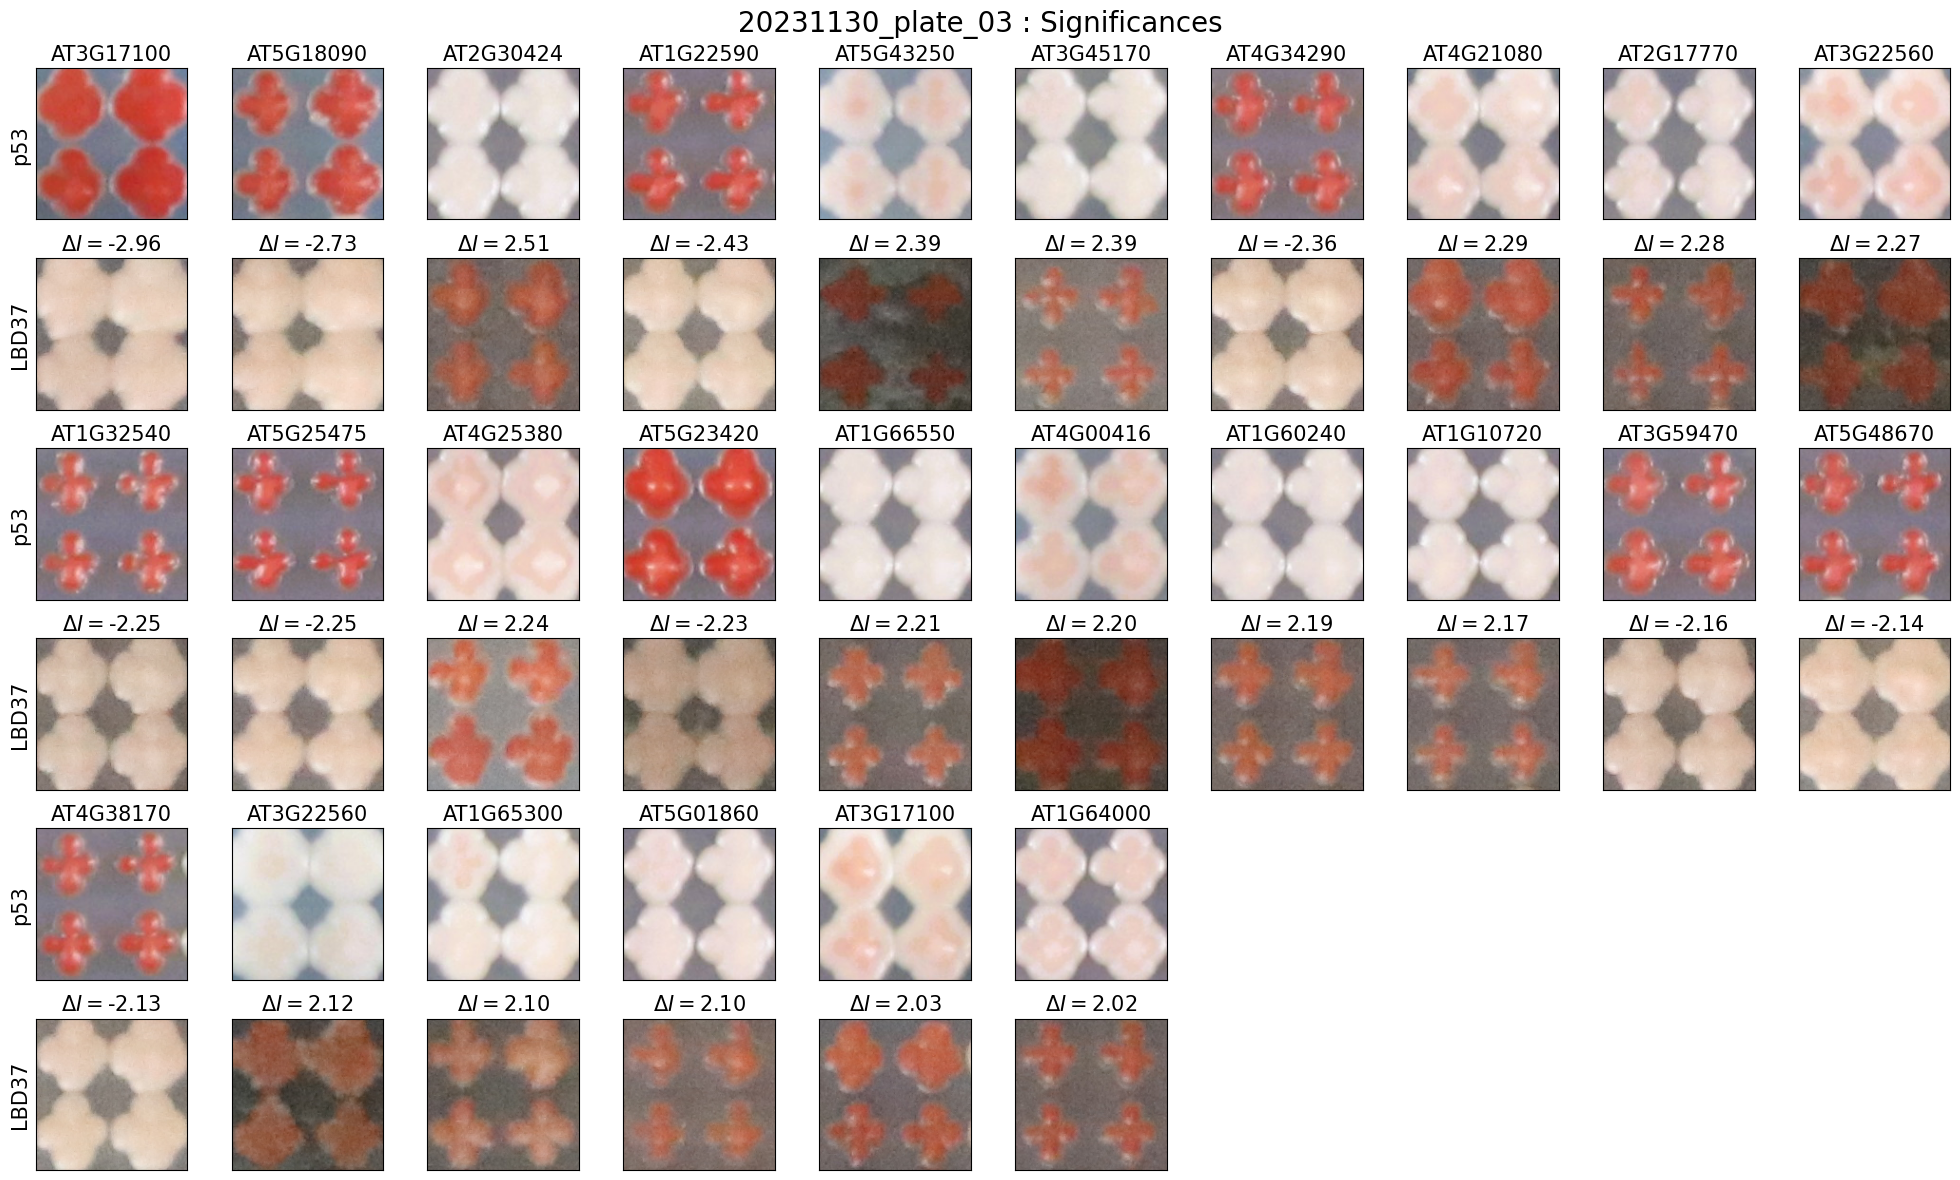

In [70]:
fs = 15
R = 80
figR = 2
fig, ax = plt.subplots(2*axrows, axcols, figsize=(figR*axcols, 2*figR*axrows), sharex=True, sharey=True)
ax = ax.reshape(2*axrows, axcols)

for i in range(len(ssignif)):
    ix, jx = i//axcols, i%axcols
    ax[2*ix, jx].set_title(ssignif.iloc[i,0], fontsize=fs)
    ax[2*ix+1, jx].set_title('$\Delta I =${:.2f}'.format(ssignif.iloc[i,7]), fontsize=fs)

    row, col = [int(foo[1:])-1 for foo in ssignif.iloc[i,1].split('-')[1:] ] 

    j = 2*ix
    for (cc,img) in zip([rawcoords, pltcoords],[rawimg,pltimg]):
        dots = cc[2*row : 2*row + 2, 2*col : 2*col + 2]
        center = np.mean(np.mean(dots, axis = 0), axis = 0).astype(int)
        rss = np.s_[center[1] - R : center[1] + R, center[0] - R : center[0] + R]
        ax[j,jx].imshow(img[rss], vmin=0, origin='upper'); j+=1

for i in range(1, 1 + axrows*axcols - len(ssignif)):
    fig.delaxes(ax[-1, -i])
    fig.delaxes(ax[-2, -i])

for i in range(axrows):
    ax[2*i,0].set_ylabel(reference_gene, fontsize=fs)
    ax[2*i + 1,0].set_ylabel(genes[gidx], fontsize=fs)

for a in ax.ravel():
    a.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)

fig.suptitle(bname + ' : Significances', fontsize=fs+5)
fig.tight_layout()
#plt.savefig('foo.jpg', dpi=200, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})